In [131]:
#analytics
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from entropy.entropy import *

from scipy.io import arff



# visuals
import matplotlib.pyplot as plt

## Import Condition Data

In [132]:
path = "data/useful/Worms/"

In [133]:
data = arff.loadarff(path+'Worms_TRAIN.arff')
print(len(data))
df_data = pd.DataFrame(data[0])

df_data.head()

2


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att892,att893,att894,att895,att896,att897,att898,att899,att900,target
0,1.660505,1.739092,1.812766,1.847148,1.901176,1.935558,1.906088,1.945381,1.925734,1.915911,...,-0.422037,-0.397478,-0.402390,-0.402390,-0.402390,-0.441683,-0.431860,-0.495712,-0.505535,b'1'
1,-0.379133,0.242145,-0.517195,-0.033979,0.587299,-0.517195,-0.172040,0.035052,0.518269,-0.103009,...,-3.623585,-2.311998,-3.278430,-2.864245,-3.278430,-3.002307,-2.864245,-2.726183,-3.071337,b'1'
2,0.534425,0.444349,0.399312,0.511906,0.669539,0.714577,0.511906,0.692058,0.489387,0.556944,...,3.934791,3.754639,4.024867,3.799677,3.777158,3.777158,3.574488,3.844715,3.574488,b'1'
3,-2.438882,-2.412564,-2.438882,-2.333611,-2.267818,-2.307294,-2.412564,-2.162547,-2.241500,-2.254659,...,-1.767783,-1.794101,-1.688830,-1.701989,-1.701989,-1.767783,-1.767783,-1.754624,-1.767783,b'1'
4,1.601259,1.601259,1.589440,1.589440,1.589440,1.589440,1.589440,1.577622,1.577622,1.577622,...,3.208625,3.244082,3.125893,3.031342,2.948610,2.854059,2.783146,2.794965,2.854059,b'1'


In [134]:
Xtrain = df_data.drop(columns=['target']).values
ytrain = df_data['target']

In [135]:
Xtrain[0].shape

(900,)

In [136]:
ytrain.shape

(181,)

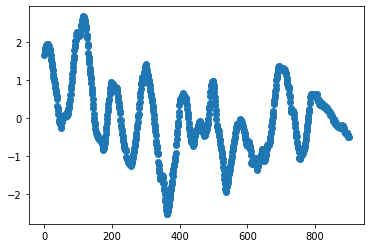

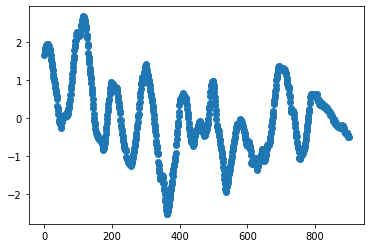

In [137]:
x_range = [x for x in range(0,len(Xtrain[0]))]

initial_fig, initial_ax = plt.subplots(1,1)
initial_ax = plt.scatter(x_range,Xtrain[0])
initial_fig

## Extract Features

### Extracting the following features from selected data

<ol>
<li>Mean Activity Level</li>
<li>Standard Deviation</li>
<li> Trimmed Mean </li>
</ol>

In [138]:
training_data_raw = Xtrain

In [139]:
def normalise(X):
    return [(x - min(X))/(max(X)-min(X)) for x in X]

In [140]:
from scipy.stats import trim_mean
    
df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

df_features['perm_entropy'] = normalise([perm_entropy(x,10) for x in training_data_raw])
df_features['sample_entropy'] = normalise([sample_entropy(x,2) for x in training_data_raw])
df_features['app_entropy'] = normalise([app_entropy(x,2) for x in training_data_raw])
df_features['svd_entropy'] = normalise([svd_entropy(x,3) for x in training_data_raw])
#df_features['spectral_entropy'] = normalise([spectral_entropy(x,100) for x in training_data_raw])

In [141]:
feature_combinations = []

feature_names = ['perm', 'sample', 'app', 'svd']
# singles
feature_combinations.append(df_features.drop(['sample_entropy', 'app_entropy', 'svd_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'app_entropy', 'svd_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'svd_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'app_entropy'],axis=1).values)




In [142]:
y_temp = ytrain.values

y = [x[0] for x in y_temp]

## Naive Bayes

In [143]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
accuracy_scores = []
f1_scores = []

for X in feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=5, scoring='f1_weighted'))

In [144]:
len(accuracy_scores)

4

In [145]:
print(np.mean(accuracy_scores,axis=1))



[0.39249249 0.4533033  0.503003   0.48618619]


1: perm
2: sample
3: app
4: svd


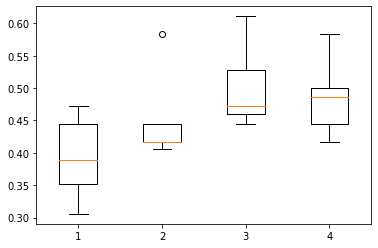

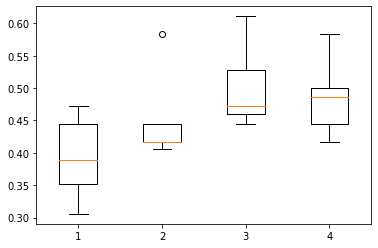

In [146]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(feature_names)+1):
    
    print(str(x) + ': '+  str(feature_names[x - 1]))
    
box_fig
    

In [147]:
import random

random_sample = random.sample(list(Xtrain), 10)

In [148]:
from statsmodels.tsa.stattools import adfuller
mean_adf = []
mean_p = []

for X in random_sample:
    result = adfuller(X)
    mean_adf.append(result[0])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    mean_p.append(result[1])
    if result[1] < 0.05:
        print("can reject")
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
print("adf_mean is: ")
print(np.mean(mean_adf))
print(np.mean(mean_p))

ADF Statistic: -2.720946
p-value: 0.070483
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
ADF Statistic: -5.201643
p-value: 0.000009
can reject
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Statistic: -2.834027
p-value: 0.053575
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
ADF Statistic: -0.906573
p-value: 0.785800
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Statistic: -5.118936
p-value: 0.000013
can reject
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
ADF Statistic: -5.769362
p-value: 0.000001
can reject
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
ADF Statistic: -10.496306
p-value: 0.000000
can reject
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
ADF Statistic: -9.487475
p-value: 0.000000
can reject
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Statistic: -1.792598
p-value: 0.384143
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
ADF Statistic: -8.190604
p-value: 0.000000
can reject
Critical Values:


### Test for Autocorrelation

In [149]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS


def dw(data):
    ols_res = OLS(data, np.ones(len(data))).fit()
    return durbin_watson(ols_res.resid)




In [150]:
mean = []
for X in random_sample:
    print(dw(X))
    mean.append(dw(X))

print("mean is: ")
print(np.mean(mean))

0.003688409230722523
0.0043021785676638025
0.0026408175792910086
0.005433219415992558
0.007866154975574462
0.013891027934152466
0.01863764535858785
0.007475373934347384
0.007053863412115282
0.021451830778636098
mean is: 
0.009244052118708343


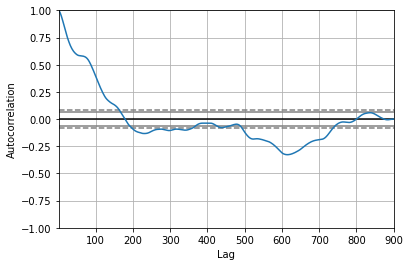

In [151]:
from pandas.plotting import autocorrelation_plot

my_plot = autocorrelation_plot(random_sample[0])

plt.show()

## Matrix Profile Feature

In [152]:
def new_discord_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[0:10]

    #top 10 discords
    top_discord_windows = []
    for x in top_discords['index']:
        window = np.arange(x,x+window_size,1)
        top_discord_windows.append(window)
    overall_discord_window = set(np.concatenate(top_discord_windows))
    discord_size = len(overall_discord_window)
    discord_probability = discord_size/time_series_size


    discord_entropy = -(discord_probability * np.log2(discord_probability))
    
    return discord_entropy
    

In [153]:
def new_motif_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]

    # top 10 motifs 
    top_motif_windows = []
    for x in top_motifs['index']:
        window = np.arange(x,x+window_size,1)
        top_motif_windows.append(window)
    overall_motif_window = set(np.concatenate(top_motif_windows))
    motif_size = len(overall_motif_window)
    motif_probability = motif_size/time_series_size

    motif_entropy = -(motif_probability * np.log2(motif_probability))
    
    return motif_entropy

In [154]:
def motif_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:5]
    entropy_motif = np.sum(np.asarray([x * np.log2(x+1) for x in top_motifs['distances']]))
    
    return entropy_motif

In [155]:
def discord_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[len(df_matrix_profile)-5:len(df_matrix_profile)] 
    entropy_discord = np.sum(np.asarray([x * np.log2(x+1) for x in top_discords['distances']]))
    
    return entropy_discord

In [156]:
def distance_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    max_discord = max(df_matrix_profile['distances'])
    entropy_distance = np.sum(np.asarray([x * np.log2(x) for x in df_matrix_profile['distances']]))
    
    return entropy_distance

In [157]:
def calculate_matrix_profile(data, window_size):
    time_series = np.array(data, dtype=float)
    matrix_profile = stumpy.stump(time_series, m=window_size, ignore_trivial=True)    
    return matrix_profile

In [158]:
import stumpy

df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

window_size = 200
matrix_profiles = [calculate_matrix_profile(x,window_size) for x in training_data_raw]

A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


In [159]:
df_features['new_motif_entropy'] = normalise([new_motif_entropy(x, window_size) for x in matrix_profiles])
df_features['new_discord_entropy'] = normalise([new_discord_entropy(x, window_size) for x in matrix_profiles])
df_features['motif_entropy'] = normalise([motif_entropy(x) for x in matrix_profiles])
df_features['discord_entropy'] = normalise([discord_entropy(x) for x in matrix_profiles])
#df_features['distance_entropy'] = normalise([distance_entropy(x) for x in matrix_profiles])

In [160]:
entropy_feature_combinations = []

entropy_feature_names = ['new_motif_entropy', 'new_discord_entropy', 'motif_entropy', 'discord_entropy']
# singles
entropy_feature_combinations.append(df_features.drop(['new_discord_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'motif_entropy'],axis=1).values)




In [161]:
accuracy_scores = []
f1_scores = []

for X in entropy_feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=5, scoring='f1_weighted'))

In [162]:
np.mean(accuracy_scores)

0.41430180180180176

In [163]:
np.mean(f1_scores)

0.35089398749757017

1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


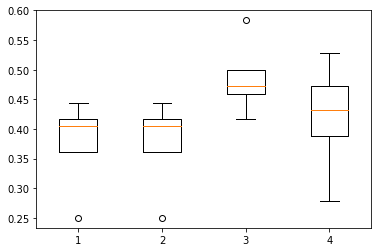

In [164]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))
    


1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


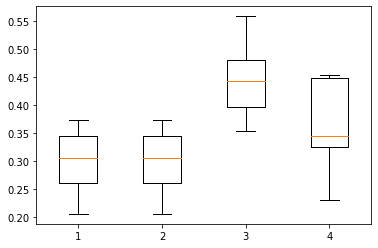

In [165]:
## F Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(f1_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))
